In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("boston.csv")

0.2166209012915364


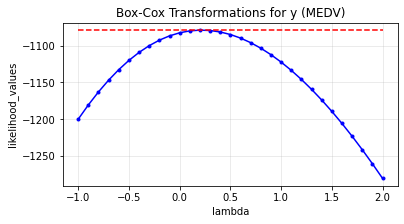

In [3]:
# Box-Cox Transformations for y (Median value of owner-occupied homes in $1000's)
from scipy import stats
fitted_data, fitted_lambda = stats.boxcox(df['MEDV'])
lamb = np.linspace(-1, 2, 31)

likelihood_values = [stats.boxcox_llf(i, df['MEDV']) for i in lamb]
fig = plt.figure(figsize=(6,3))
plt.plot(lamb, likelihood_values, 'b.-')
plt.hlines(max(likelihood_values), -1, 2, colors='red', linestyles='--')
plt.grid(alpha = 0.3)
plt.xlabel('lambda')
plt.ylabel('likelihood_values')
plt.title('Box-Cox Transformations for y (MEDV)')
# plt.vlines(lamb[likelihood_values.index(max(likelihood_values))], -28000, max(likelihood_values))
# plt.ylim(-26000, -10000)
print(fitted_lambda)

In [4]:
df['lnMEDV'] = np.log(df['MEDV'])

In [5]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'MEDV', 'lnMEDV'],
      dtype='object')

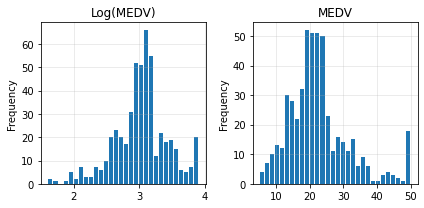

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
df['lnMEDV'].plot.hist(ax = axes[0], title = "Log(MEDV)", rwidth=0.8, bins=30)
axes[0].grid(alpha=0.3)
df['MEDV'].plot.hist(ax = axes[1], title = "MEDV", rwidth=0.8, bins=30)
axes[1].grid(alpha=0.3)
plt.tight_layout()

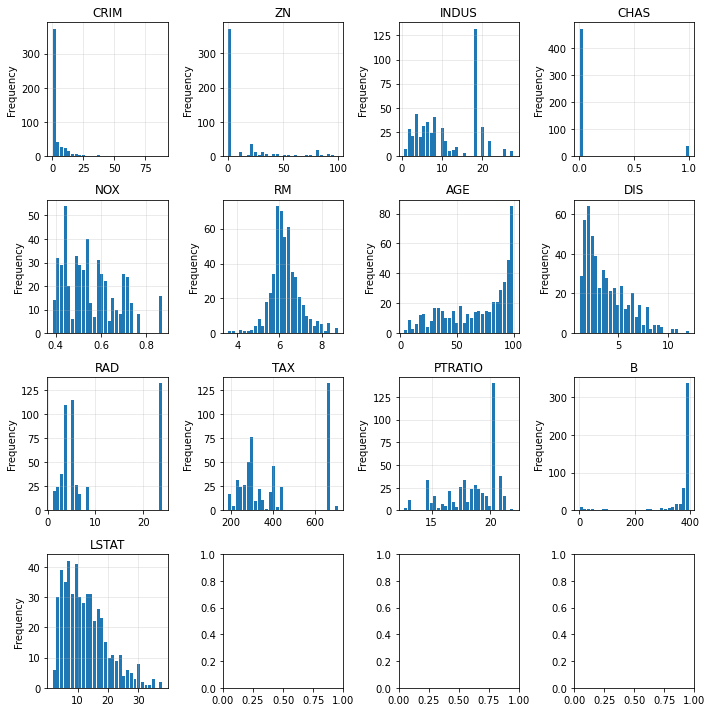

In [7]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i in range(len(df.columns[:-2])):
    df[df.columns[i]].plot.hist(ax = axes[i//4][i%4], title = df.columns[i], rwidth=0.8, bins=30)
    axes[i//4][i%4].grid(alpha=0.3)
plt.tight_layout()

<AxesSubplot:>

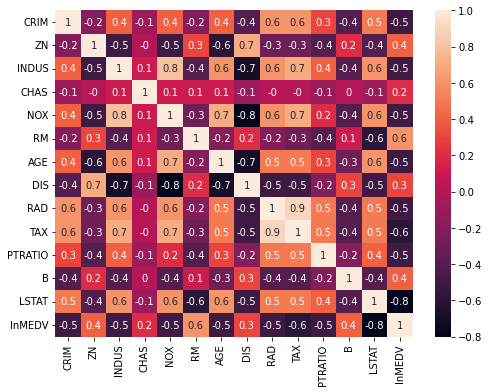

In [8]:
plt.figure(figsize=(8,6))
sns.heatmap(round(df[df.columns.drop('MEDV')].corr(),1), annot=True)

In [9]:
# Split training dataset and validation dataset
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(df.drop(['MEDV'], axis=1), test_size=0.5, random_state=1)

In [10]:
training_set = training_set.reset_index(drop=True)
validation_set = validation_set.reset_index(drop=True)

In [11]:
# Data explore
# sns.pairplot(df)

In [12]:
from statsmodels.formula.api import ols ,wls
import statsmodels.stats.api as sms
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.diagnostic as smd

In [13]:
# Run simple regression for every X
reg_result = []
reg_resid = {}
reg_fitval = {}
for i in training_set.columns.drop('lnMEDV'):
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    # beta
    beta = reg_model.params.iloc[1]
    # t-value
    tValue = reg_model.tvalues.iloc[1]
    # Durbin-Watson test statiitcs
    dwt = sms.durbin_watson(reg_model.resid)
    # Jarque-Bera test Chi^2 two-tail prob
    jbt = sms.jarque_bera(reg_model.resid)[1]
    # Breusch-Pagan Test p-value
    bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]
    reg_result.append([beta, abs(tValue), dwt, jbt, bpt])
    reg_fitval[i] = reg_model.fittedvalues
    reg_resid[i] = reg_model.resid

In [14]:
pd.set_option('display.float_format', '{:.3f}'.format)
simple_reg_result = pd.DataFrame(reg_result, index=training_set.columns.drop('lnMEDV'), columns=['beta','abs(tValue)','Durbin-Watson test','Jarque-Bera test (pValue)','Breusch-Pagan (pValue)']).sort_values('abs(tValue)', ascending=False)
simple_reg_result

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


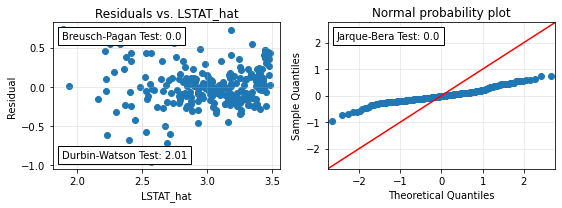

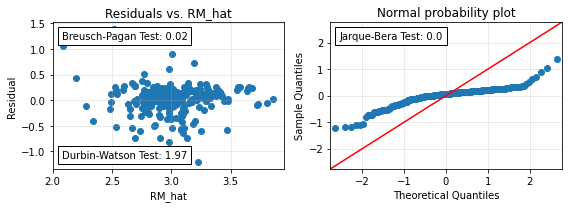

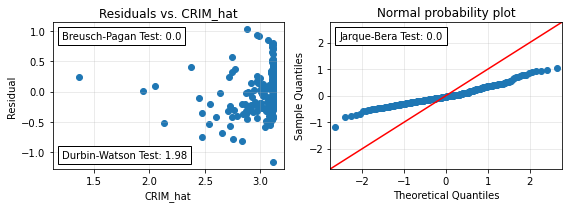

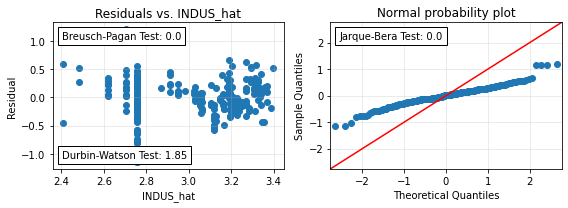

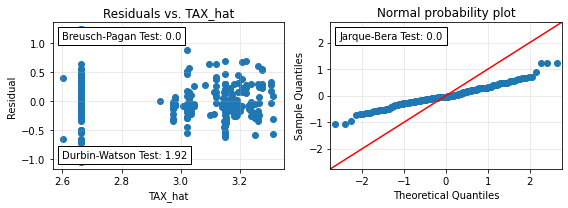

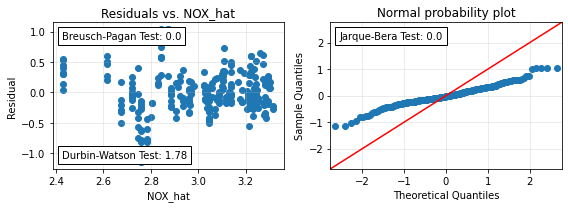

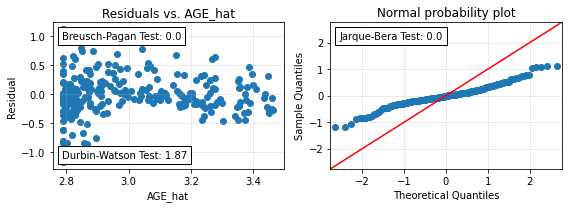

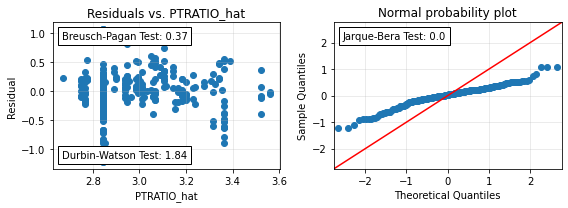

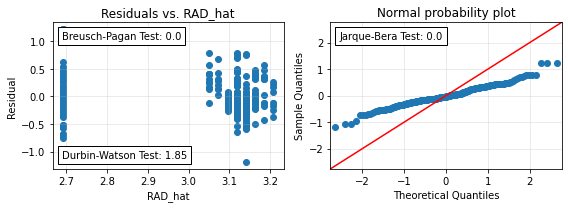

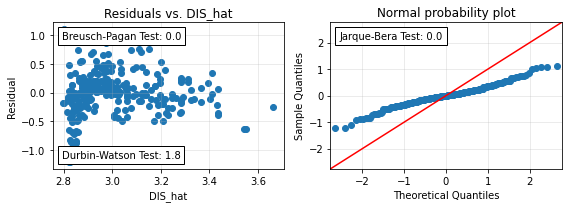

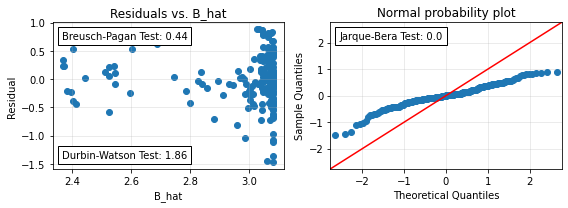

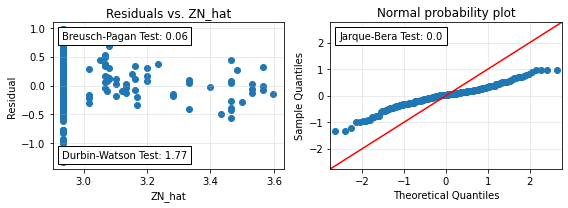

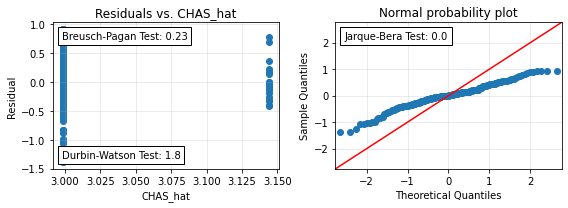

In [15]:
from matplotlib.offsetbox import AnchoredText
for i in simple_reg_result.index:
        fig, axs = plt.subplots(1, 2, figsize=(8,3))

        axs[0].scatter(reg_fitval[i], reg_resid[i])
        axs[0].grid(alpha = 0.3)
        axs[0].set_title('Residuals vs. '+i+'_hat')
        axs[0].set_ylabel('Residual')
        axs[0].set_xlabel(i+'_hat')
        anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(simple_reg_result.loc[i,'Breusch-Pagan (pValue)'],2)), loc=2)
        axs[0].add_artist(anchored_text)
        anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(simple_reg_result.loc[i,'Durbin-Watson test'],2)), loc=3)
        axs[0].add_artist(anchored_text)


        sm.qqplot(reg_resid[i], line="45", ax=axs[1])
        axs[1].grid(alpha = 0.3)
        axs[1].set_title('Normal probability plot')
        anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(simple_reg_result.loc[i,'Jarque-Bera test (pValue)'],2)), loc=2)
        axs[1].add_artist(anchored_text)
        fig.tight_layout()

In [16]:
candidate = simple_reg_result[simple_reg_result['abs(tValue)']>2]
candidate

,beta,abs(tValue),Durbin-Watson test,Jarque-Bera test (pValue),Breusch-Pagan (pValue)
LSTAT,-0.045,21.837,2.009,0.000,0.000
RM,0.391,13.200,1.975,0.000,0.017
CRIM,-0.026,11.447,1.985,0.002,0.000
INDUS,-0.036,11.315,1.852,0.000,0.000
TAX,-0.001,10.452,1.919,0.000,0.000
NOX,-1.852,9.969,1.784,0.000,0.000
AGE,-0.007,8.907,1.874,0.000,0.000
PTRATIO,-0.095,8.906,1.837,0.000,0.369
RAD,-0.022,8.410,1.854,0.001,0.000
DIS,0.079,7.088,1.799,0.001,0.000


In [21]:
partial_f_test_treshold = 0.1

In [23]:
# stepwise regression processing
X_candidate = candidate.index[1:]
X_candidate_collection = [candidate.index[0]]

while len(X_candidate) > 0:
    add_list = {}
    for i in X_candidate:
        
        syntax_var = str(X_candidate_collection+[i]).replace("[","").replace("]","").replace("'","").replace(","," +")
        reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
        
        hypotheses = '('+i+' = 0)'
        partial_f_test = reg_model.f_test(hypotheses).pvalue
        add_list[i] = partial_f_test
        print("model contains: "+syntax_var)
    add_list = pd.Series(add_list).sort_values()
    print(add_list.iloc[[0]])
    if add_list.iloc[0] < partial_f_test_treshold:
        X_candidate_collection.append(add_list.index[0])
    else:
        break
    # check whether affect previous variables
    syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
    reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
    variables_pValue = reg_model.pvalues[1:]
    delete_var = variables_pValue.where(variables_pValue > 0.1).dropna().index.to_list()
    [X_candidate_collection.remove(delete) for delete in delete_var]

    X_candidate = X_candidate.drop(add_list.index[0])
    

model contains: LSTAT + RM
model contains: LSTAT + CRIM
model contains: LSTAT + INDUS
model contains: LSTAT + TAX
model contains: LSTAT + NOX
model contains: LSTAT + AGE
model contains: LSTAT + PTRATIO
model contains: LSTAT + RAD
model contains: LSTAT + DIS
model contains: LSTAT + B
model contains: LSTAT + ZN
CRIM    3.7969824445628305e-10
dtype: object
model contains: LSTAT + CRIM + RM
model contains: LSTAT + CRIM + INDUS
model contains: LSTAT + CRIM + TAX
model contains: LSTAT + CRIM + NOX
model contains: LSTAT + CRIM + AGE
model contains: LSTAT + CRIM + PTRATIO
model contains: LSTAT + CRIM + RAD
model contains: LSTAT + CRIM + DIS
model contains: LSTAT + CRIM + B
model contains: LSTAT + CRIM + ZN
PTRATIO    1.929076502419436e-06
dtype: object
model contains: LSTAT + CRIM + PTRATIO + RM
model contains: LSTAT + CRIM + PTRATIO + INDUS
model contains: LSTAT + CRIM + PTRATIO + TAX
model contains: LSTAT + CRIM + PTRATIO + NOX
model contains: LSTAT + CRIM + PTRATIO + AGE
model contains: LST

In [24]:
syntax_var = str(X_candidate_collection).replace("[","").replace("]","").replace("'","").replace(","," +")
reg_model = ols('lnMEDV ~ '+ syntax_var, data=training_set).fit()
reg_model_validation = ols('lnMEDV ~ '+ syntax_var, data=validation_set).fit()


In [25]:
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     87.30
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           1.94e-74
Time:                        16:29:38   Log-Likelihood:                 53.831
No. Observations:                 253   AIC:                            -85.66
Df Residuals:                     242   BIC:                            -46.80
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1543      0.304     13.682      0.0

In [26]:
print(reg_model_validation.summary())

                            OLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     93.34
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           3.46e-77
Time:                        16:29:40   Log-Likelihood:                 75.928
No. Observations:                 253   AIC:                            -129.9
Df Residuals:                     242   BIC:                            -90.99
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1713      0.284     14.703      0.0

<AxesSubplot:>

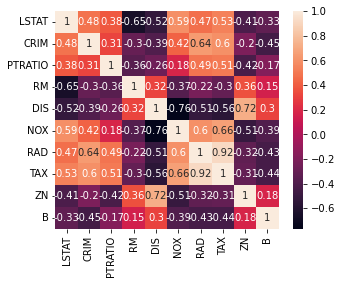

In [27]:
plt.figure(figsize=(5,4))
sns.heatmap(training_set[X_candidate_collection].corr(), annot=True)

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [29]:
VIF = pd.DataFrame()
VIF['feature']  = X_candidate_collection
VIF['VIF'] = [variance_inflation_factor(training_set[X_candidate_collection].values, i) for i in range(training_set[X_candidate_collection].shape[1])]
VIF

,feature,VIF
0,LSTAT,10.082
1,CRIM,2.305
2,PTRATIO,101.074
3,RM,76.150
4,DIS,15.244
5,NOX,54.360
6,RAD,15.851
7,TAX,60.525
8,ZN,3.654
9,B,21.296


In [30]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(reg_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(reg_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(reg_model.resid, reg_model.model.exog)[1]

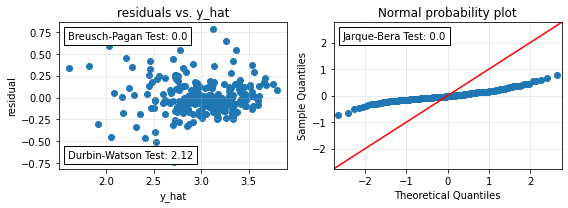

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(reg_model.fittedvalues, reg_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)

sm.qqplot(reg_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

Text(0.5, 1.0, 'Residual Distribution')

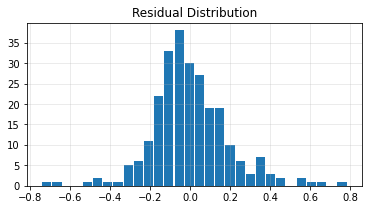

In [32]:
ax1 = reg_model.resid.hist(bins=30, figsize=(6,3), rwidth=0.9)
ax1.grid(alpha = 0.3)
ax1.set_title('Residual Distribution')

In [33]:
residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
residual_data.columns = ['abs_residual', 'y_hat']
residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

residual_data_valid = pd.concat([abs(reg_model_validation.resid),reg_model_validation.fittedvalues], axis=1)
residual_data_valid.columns = ['abs_residual', 'y_hat']
residual_model_valid = ols('abs_residual ~ y_hat', data=residual_data_valid).fit()

In [34]:
wls_whole_model = wls('lnMEDV ~ '+ syntax_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
wls_whole_model_valid = wls('lnMEDV ~ '+ syntax_var, data=validation_set, weights = 1/residual_model_valid.fittedvalues).fit()
print(wls_whole_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.800
Model:                            WLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     96.95
Date:                Wed, 25 Oct 2023   Prob (F-statistic):           9.15e-79
Time:                        16:32:31   Log-Likelihood:                 67.438
No. Observations:                 253   AIC:                            -112.9
Df Residuals:                     242   BIC:                            -74.01
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.7368      0.288     12.976      0.0

In [35]:
# Durbin-Watson test statiitcs
dwt = sms.durbin_watson(wls_whole_model.resid)
# Jarque-Bera test Chi^2 two-tail prob
jbt = sms.jarque_bera(wls_whole_model.resid)[1]
# Breusch-Pagan Test p-value
bpt = sms.het_breuschpagan(wls_whole_model.resid, wls_whole_model.model.exog)[1]

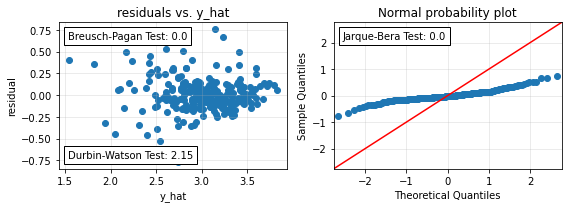

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(8,3))

axs[0].scatter(wls_whole_model.fittedvalues, wls_whole_model.resid)
axs[0].grid(alpha = 0.3)
axs[0].set_title('residuals vs. y_hat')
axs[0].set_ylabel('residual')
axs[0].set_xlabel('y_hat')
anchored_text = AnchoredText("Breusch-Pagan Test: "+str(round(bpt,2)), loc=2)
axs[0].add_artist(anchored_text)
anchored_text = AnchoredText("Durbin-Watson Test: "+str(round(dwt,2)), loc=3)
axs[0].add_artist(anchored_text)


sm.qqplot(wls_whole_model.resid, line="45", ax=axs[1])
axs[1].grid(alpha = 0.3)
axs[1].set_title('Normal probability plot')
anchored_text = AnchoredText("Jarque-Bera Test: "+str(round(jbt,2)), loc=2)
axs[1].add_artist(anchored_text)
fig.tight_layout()

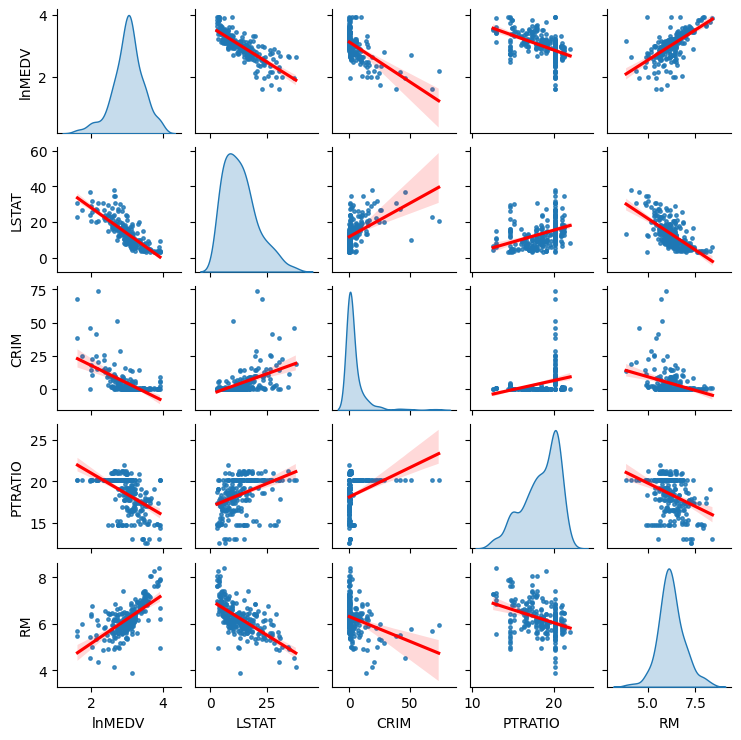

In [46]:
# Data explore
g = sns.pairplot(training_set[['lnMEDV']+X_candidate_collection], kind="reg", corner=False, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{'s':6}}, diag_kind='kde', height=1.5)

In [37]:
def press_criterion(reg_data, ind_variables, freq):
    press = 0
    for i in range(0, len(reg_data)-freq+1, freq):
        wls_model = wls('lnMEDV ~ '+ind_variables, data=reg_data.drop(range(i,i+freq)), weights = 1/residual_model.fittedvalues.drop(range(i,i+freq))).fit()
        press += ((wls_model.predict(reg_data[ind_variables.split(' + ')].iloc[i:i+freq]).values[0] - reg_data['lnMEDV'][i:i+freq])**2).sum()
    return press

def mallows_cp(reg_data, muliple_variable_list, wls_whole_model, wls_model):
    c = wls_model.ssr/wls_whole_model.mse_resid-(len(reg_data)-2*(len(muliple_variable_list)+1)+1)
    return c
    
def combs(a):
    if len(a) == 0:
        return [[]]
    cs = []
    for c in combs(a[1:]):
        cs += [c, c+[a[0]]]
    return cs

In [38]:
combs(X_candidate_collection)[1:]

[['LSTAT'],
 ['CRIM'],
 ['CRIM', 'LSTAT'],
 ['PTRATIO'],
 ['PTRATIO', 'LSTAT'],
 ['PTRATIO', 'CRIM'],
 ['PTRATIO', 'CRIM', 'LSTAT'],
 ['RM'],
 ['RM', 'LSTAT'],
 ['RM', 'CRIM'],
 ['RM', 'CRIM', 'LSTAT'],
 ['RM', 'PTRATIO'],
 ['RM', 'PTRATIO', 'LSTAT'],
 ['RM', 'PTRATIO', 'CRIM'],
 ['RM', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['DIS'],
 ['DIS', 'LSTAT'],
 ['DIS', 'CRIM'],
 ['DIS', 'CRIM', 'LSTAT'],
 ['DIS', 'PTRATIO'],
 ['DIS', 'PTRATIO', 'LSTAT'],
 ['DIS', 'PTRATIO', 'CRIM'],
 ['DIS', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['DIS', 'RM'],
 ['DIS', 'RM', 'LSTAT'],
 ['DIS', 'RM', 'CRIM'],
 ['DIS', 'RM', 'CRIM', 'LSTAT'],
 ['DIS', 'RM', 'PTRATIO'],
 ['DIS', 'RM', 'PTRATIO', 'LSTAT'],
 ['DIS', 'RM', 'PTRATIO', 'CRIM'],
 ['DIS', 'RM', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['NOX'],
 ['NOX', 'LSTAT'],
 ['NOX', 'CRIM'],
 ['NOX', 'CRIM', 'LSTAT'],
 ['NOX', 'PTRATIO'],
 ['NOX', 'PTRATIO', 'LSTAT'],
 ['NOX', 'PTRATIO', 'CRIM'],
 ['NOX', 'PTRATIO', 'CRIM', 'LSTAT'],
 ['NOX', 'RM'],
 ['NOX', 'RM', 'LSTAT'],
 ['NOX', 'RM', 'CR

In [42]:
powerset_var = combs(X_candidate_collection)[1:]
criterions = []
k = 0
for i in powerset_var:
    ind_var = str(i).replace("'",'').replace("[",'').replace("]",'').replace(",",' +')
    reg_model = ols('lnMEDV ~ '+ind_var, data=training_set).fit()
    
    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()
    try:
        wls_model = wls('lnMEDV ~ '+ind_var, data=training_set, weights = 1/residual_model.fittedvalues).fit()
    except:
        p = len(i)
        sse = np.nan
        req = np.nan
        rsq_a = np.nan
        cp = np.nan
        aic = np.nan
        bic = np.nan
        press = np.nan

    
    p = len(i)
    sse = wls_model.ssr
    rsq = wls_model.rsquared
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i, wls_whole_model, wls_model)
    aic = wls_model.aic
    bic = wls_model.bic
    # press = press_criterion(training_set, ind_var, 1)
    press = np.nan
    criterions.append([ind_var, p,sse,rsq,rsq_a,cp,aic,bic,press])
    k+=1
    print(k)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


/Users/wei/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:745: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.weights)[:, None] * x
/Users/wei/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:743: RuntimeWarning: invalid value encountered in sqrt
  return x * np.sqrt(self.weights)


43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
3

In [43]:
criterions_df = pd.DataFrame(criterions, columns=['ind_variables','p','SSE','R2','adj_R2','Cp','AIC','BIC','PRESS']).set_index('ind_variables')

In [56]:
criterions_df['No.'] = range(len(criterions))
criterions_df

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
LSTAT,1,79.849,0.666,0.664,56.030,-7.565,-0.499,NaN,55.030,0
CRIM,1,108.528,0.290,0.287,165.946,163.329,170.396,NaN,164.946,1
CRIM + LSTAT,2,73.239,0.694,0.692,32.698,-32.134,-21.533,NaN,30.698,2
PTRATIO,1,125.390,0.241,0.238,230.570,212.961,220.028,NaN,229.570,3
PTRATIO + LSTAT,2,75.764,0.703,0.700,42.375,-31.857,-21.257,NaN,40.375,4
...,...,...,...,...,...,...,...,...,...,...
B + ZN + TAX + RAD + NOX + DIS + RM + CRIM + LSTAT,9,64.802,0.793,0.785,14.361,-101.944,-66.610,NaN,5.361,1018
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO,8,64.802,0.793,0.785,12.361,-101.944,-66.610,NaN,4.361,1019
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + LSTAT,9,70.139,0.785,0.777,34.814,-84.112,-48.778,NaN,25.814,1020


In [57]:
criterions_df['abs(Cp)'] = abs(criterions_df['p'] - criterions_df['Cp'])

In [68]:
c1 = criterions_df.sort_values('abs(Cp)').head(50)
c1

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,NaN,0.000,1022
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,NaN,0.147,766
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,NaN,0.277,510
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,NaN,0.474,254
ZN + TAX + RAD + NOX + DIS + RM,6,64.433,0.771,0.764,6.947,-89.388,-57.587,NaN,0.947,503
B + ZN + TAX + RAD + NOX + DIS + RM,7,64.397,0.774,0.765,8.810,-90.176,-54.842,NaN,1.810,1015
TAX + RAD + NOX + DIS + RM,5,65.117,0.763,0.757,7.570,-83.899,-55.632,NaN,2.570,247
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO,7,64.678,0.789,0.782,9.887,-100.458,-68.658,NaN,2.887,507
ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT,8,64.433,0.771,0.764,10.947,-89.388,-57.587,NaN,2.947,502


In [69]:
c2 = criterions_df.sort_values('Cp').head(10)
c2

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
ZN + TAX + RAD + NOX + DIS + RM,6,64.433,0.771,0.764,6.947,-89.388,-57.587,NaN,0.947,503
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,NaN,0.474,254
TAX + RAD + NOX + DIS + RM,5,65.117,0.763,0.757,7.570,-83.899,-55.632,NaN,2.570,247
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,NaN,0.277,510
B + ZN + TAX + RAD + NOX + DIS + RM,7,64.397,0.774,0.765,8.810,-90.176,-54.842,NaN,1.810,1015
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,NaN,0.147,766
RAD + NOX + DIS + RM,4,66.172,0.758,0.752,9.612,-79.018,-54.285,NaN,5.612,119
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO,7,64.678,0.789,0.782,9.887,-100.458,-68.658,NaN,2.887,507
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,NaN,0.000,1022


In [70]:
c3 = criterions_df.sort_values('adj_R2', ascending=False).head(10)
c3

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
B + TAX + RAD + NOX + DIS + RM,6,100.653,0.918,0.916,145.762,11.825,36.559,NaN,139.762,759
TAX + RAD + DIS + RM + PTRATIO + CRIM,6,83.751,0.902,0.899,80.983,-31.456,-6.723,NaN,74.983,221
B + NOX + DIS + RM,4,101.219,0.866,0.864,143.934,34.072,51.739,NaN,139.934,567
NOX + DIS + RM + PTRATIO,4,96.445,0.863,0.861,125.636,8.313,25.980,NaN,121.636,59
B + RAD + NOX + DIS + RM + PTRATIO,6,91.831,0.864,0.861,111.951,-14.423,10.311,NaN,105.951,635
B + ZN + RAD + NOX + DIS + RM + PTRATIO,7,90.928,0.853,0.849,110.490,-13.504,14.764,NaN,103.490,891
ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM,7,82.456,0.847,0.843,78.021,-33.145,-4.878,NaN,71.021,477
ZN + TAX + DIS + RM + CRIM,5,82.657,0.844,0.841,74.793,-26.554,-5.354,NaN,69.793,409
B + ZN + TAX + NOX + DIS + RM + CRIM,7,81.403,0.842,0.838,73.987,-31.796,-3.529,NaN,66.987,953


In [71]:
press_list = []
for i in c1.index:
    press_list.append(press_criterion(training_set, i, 1))
    print(i)

B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
ZN + TAX + RAD + NOX + DIS + RM
B + ZN + TAX + RAD + NOX + DIS + RM
TAX + RAD + NOX + DIS + RM
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO
ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT
RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
B + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM + LSTAT
B + ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT
ZN + TAX + RAD + NOX + DIS + RM + CRIM + LSTAT
B + ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM + LSTAT
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO
TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT
ZN + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
B + ZN + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT
ZN + TAX + RAD + DIS + RM + PTRATIO
B + TAX + RAD + DIS + RM + PTRATIO + CRIM + L

In [74]:
c1['PRESS'] = press_list

In [77]:
criterions_df.loc[c1.index,"PRESS"] = press_list

In [79]:
criterions_df.sort_values('abs(Cp)').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,11.252,0.000,1022
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,11.360,0.147,766
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,11.152,0.277,510
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,11.264,0.474,254
ZN + TAX + RAD + NOX + DIS + RM,6,64.433,0.771,0.764,6.947,-89.388,-57.587,20.467,0.947,503
B + ZN + TAX + RAD + NOX + DIS + RM,7,64.397,0.774,0.765,8.810,-90.176,-54.842,19.921,1.810,1015
TAX + RAD + NOX + DIS + RM,5,65.117,0.763,0.757,7.570,-83.899,-55.632,20.795,2.570,247
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO,7,64.678,0.789,0.782,9.887,-100.458,-68.658,19.380,2.887,507
ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT,8,64.433,0.771,0.764,10.947,-89.388,-57.587,11.245,2.947,502


In [80]:
criterions_df.sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.331,0.796,0.788,8.723,-110.345,-75.011,11.152,0.277,510
ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT,8,64.433,0.771,0.764,10.947,-89.388,-57.587,11.245,2.947,502
B + ZN + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,10,63.142,0.800,0.792,10.000,-112.876,-74.009,11.252,0.000,1022
TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,63.540,0.790,0.783,7.526,-107.521,-75.720,11.264,0.474,254
B + ZN + TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT,9,64.397,0.774,0.765,12.810,-90.176,-54.842,11.315,3.810,1014
B + TAX + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,9,63.365,0.795,0.787,8.853,-110.348,-75.014,11.360,0.147,766
RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,7,64.809,0.784,0.778,10.386,-102.639,-74.372,11.391,3.386,126
ZN + RAD + NOX + DIS + RM + PTRATIO + CRIM + LSTAT,8,64.896,0.786,0.779,12.723,-101.995,-70.194,11.409,4.723,382
TAX + RAD + NOX + DIS + PTRATIO + CRIM + LSTAT,7,65.117,0.763,0.757,11.570,-83.899,-55.632,11.423,4.570,246


In [82]:
criterions_df.sort_values('adj_R2', ascending=False).head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS,abs(Cp),No.
ind_variables,,,,,,,,,,
B + TAX + RAD + NOX + DIS + RM,6,100.653,0.918,0.916,145.762,11.825,36.559,NaN,139.762,759
TAX + RAD + DIS + RM + PTRATIO + CRIM,6,83.751,0.902,0.899,80.983,-31.456,-6.723,NaN,74.983,221
B + NOX + DIS + RM,4,101.219,0.866,0.864,143.934,34.072,51.739,NaN,139.934,567
NOX + DIS + RM + PTRATIO,4,96.445,0.863,0.861,125.636,8.313,25.980,NaN,121.636,59
B + RAD + NOX + DIS + RM + PTRATIO,6,91.831,0.864,0.861,111.951,-14.423,10.311,NaN,105.951,635
B + ZN + RAD + NOX + DIS + RM + PTRATIO,7,90.928,0.853,0.849,110.490,-13.504,14.764,NaN,103.490,891
ZN + TAX + RAD + DIS + RM + PTRATIO + CRIM,7,82.456,0.847,0.843,78.021,-33.145,-4.878,NaN,71.021,477
ZN + TAX + DIS + RM + CRIM,5,82.657,0.844,0.841,74.793,-26.554,-5.354,NaN,69.793,409
B + ZN + TAX + NOX + DIS + RM + CRIM,7,81.403,0.842,0.838,73.987,-31.796,-3.529,NaN,66.987,953


In [38]:
criterions_df.sort_values('PRESS').head(10)

,p,SSE,R2,adj_R2,Cp,AIC,BIC,PRESS
ind_variables,,,,,,,,
RM + PTRATIO + CRIM + LSTAT,4,67.392,0.771,0.768,4.000,-93.359,-75.693,12.253
PTRATIO + CRIM + LSTAT,3,71.058,0.724,0.721,15.488,-53.359,-39.226,12.578
RM + CRIM + LSTAT,3,68.402,0.750,0.747,5.714,-75.886,-61.752,13.128
CRIM + LSTAT,2,73.239,0.694,0.692,21.516,-32.134,-21.533,13.670
RM + PTRATIO + LSTAT,3,72.585,0.762,0.759,21.109,-68.917,-54.783,13.947
PTRATIO + LSTAT,2,75.764,0.703,0.700,30.808,-31.857,-21.257,14.186
RM + LSTAT,2,75.392,0.741,0.739,29.439,-49.527,-38.926,15.368
LSTAT,1,79.849,0.666,0.664,43.840,-7.565,-0.499,15.858
RM + PTRATIO + CRIM,3,86.881,0.733,0.730,73.719,-7.145,6.988,18.254


In [47]:
Top3Model = criterions_df.sort_values('PRESS').index[:3].values
col = Top3Model.repeat(2)
idx = ['p'] + [i+'_b' for i in X_candidate_collection] + [i+'_std(b)' for i in X_candidate_collection] + ['SSE', 'PRESS', 'Cp', 'MSE'	,'MSPR', 'adj_R2']

assessment_table = pd.DataFrame(index=idx, columns=[j+' (Training)' if i%2==0 else j+' (Validation)' for i,j in enumerate(col)])
for i in Top3Model:
    # insample
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=training_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]

    sse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model, wls_model)

    press = press_criterion(training_set, i, 1)
    mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).sum()/(wls_model.df_resid)

    assessment_table.loc['p',i+' (Training)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Training)'] = beta
    assessment_table.loc[beta_std.index,i+' (Training)'] = beta_std
    assessment_table.loc['SSE',i+' (Training)'] = sse
    assessment_table.loc['PRESS',i+' (Training)'] = press
    assessment_table.loc['Cp',i+' (Training)'] = cp
    assessment_table.loc['MSE',i+' (Training)'] = mse
    assessment_table.loc['MSPR',i+' (Training)'] = mspr
    assessment_table.loc['adj_R2',i+' (Training)'] = rsq_a


    # out of sample
    reg_model = ols('lnMEDV ~ '+i, data=validation_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=validation_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]
    
    sse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model_valid, wls_model)

    press = press_criterion(training_set, i, 1)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).mean()

    assessment_table.loc['p',i+' (Validation)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Validation)'] = beta
    assessment_table.loc[beta_std.index,i+' (Validation)'] = beta_std
    assessment_table.loc['SSE',i+' (Validation)'] = sse
    assessment_table.loc['PRESS',i+' (Validation)'] = press
    assessment_table.loc['Cp',i+' (Validation)'] = cp
    assessment_table.loc['MSE',i+' (Validation)'] = mse

    assessment_table.loc['adj_R2',i+' (Validation)'] = rsq_a

In [48]:
print(wls_model.summary())

                            WLS Regression Results                            
Dep. Variable:                 lnMEDV   R-squared:                       0.731
Model:                            WLS   Adj. R-squared:                  0.728
Method:                 Least Squares   F-statistic:                     225.3
Date:                Tue, 24 Oct 2023   Prob (F-statistic):           1.22e-70
Time:                        23:14:20   Log-Likelihood:                 39.621
No. Observations:                 253   AIC:                            -71.24
Df Residuals:                     249   BIC:                            -57.11
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.2930      0.159     14.441      0.0

In [49]:
assessment_table

,RM + PTRATIO + CRIM + LSTAT (Training),RM + PTRATIO + CRIM + LSTAT (Validation),PTRATIO + CRIM + LSTAT (Training),PTRATIO + CRIM + LSTAT (Validation),RM + CRIM + LSTAT (Training),RM + CRIM + LSTAT (Validation)
p,4,4,3,3,3,3
LSTAT_b,-0.029,-0.031,-0.037,-0.039,-0.031,-0.033
CRIM_b,-0.009,-0.008,-0.009,-0.006,-0.010,-0.010
PTRATIO_b,-0.027,-0.035,-0.034,-0.045,NaN,NaN
RM_b,0.157,0.160,NaN,NaN,0.176,0.188
LSTAT_std(b),0.003,0.003,0.002,0.002,0.003,0.003
CRIM_std(b),0.002,0.002,0.002,0.002,0.002,0.002
PTRATIO_std(b),0.006,0.006,0.007,0.007,NaN,NaN
RM_std(b),0.023,0.021,NaN,NaN,0.024,0.022
SSE,11.507,10.407,12.028,11.615,12.413,11.684


In [50]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[0].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[0].split(' + ')].values, i) for i in range(training_set[Top3Model[0].split(' + ')].shape[1])]
VIF

,feature,VIF
0,RM,38.266
1,PTRATIO,55.012
2,CRIM,1.556
3,LSTAT,6.938


In [51]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[1].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[1].split(' + ')].values, i) for i in range(training_set[Top3Model[1].split(' + ')].shape[1])]
VIF

,feature,VIF
0,PTRATIO,4.910
1,CRIM,1.520
2,LSTAT,5.869


In [52]:
VIF = pd.DataFrame()
VIF['feature']  = Top3Model[2].split(' + ')
VIF['VIF'] = [variance_inflation_factor(training_set[Top3Model[2].split(' + ')].values, i) for i in range(training_set[Top3Model[2].split(' + ')].shape[1])]
VIF

,feature,VIF
0,RM,3.416
1,CRIM,1.543
2,LSTAT,4.335


In [171]:
VIF = pd.DataFrame()
name = criterions_df[criterions_df['No.']==510].index.to_list()[0].split(' + ')
name.remove('PTRATIO')
name.remove('NOX')
name.remove('TAX')
name.remove('RM')
VIF['feature']  = name
VIF['VIF'] = [variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])]
VIF

,feature,VIF
0,ZN,2.467
1,RAD,3.685
2,DIS,4.284
3,CRIM,2.136
4,LSTAT,4.215


In [154]:
Top2Model = []
# Top2Model.append(str(VIF['feature'].values).replace(' '," + ").replace("'","").replace("[","").replace("]",""))

In [155]:
VIF = pd.DataFrame()
name = criterions_df[criterions_df['No.']==502].index.to_list()[0].split(' + ')
name.remove('PTRATIO')
name.remove('NOX')
name.remove('TAX')
# name.remove('RM')
VIF['feature']  = name
VIF['VIF'] = [variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])]
VIF

,feature,VIF
0,ZN,2.467
1,RAD,3.685
2,DIS,4.284
3,CRIM,2.136
4,LSTAT,4.215


In [156]:
Top2Model.append(str(VIF['feature'].values).replace(' '," + ").replace("'","").replace("[","").replace("]",""))

In [157]:
VIF = pd.DataFrame()
name = criterions_df[criterions_df['No.']==254].index.to_list()[0].split(' + ')
name.remove('PTRATIO')
name.remove('NOX')
name.remove('TAX')
name.remove('RM')
VIF['feature']  = name
VIF['VIF'] = [variance_inflation_factor(training_set[name].values, i) for i in range(training_set[name].shape[1])]
VIF

,feature,VIF
0,RAD,3.659
1,DIS,1.835
2,CRIM,2.078
3,LSTAT,3.735


In [158]:
Top2Model.append(str(VIF['feature'].values).replace(' '," + ").replace("'","").replace("[","").replace("]",""))

In [165]:
Top2Model = np.array(Top2Model)

In [166]:
# Top3Model = criterions_df.sort_values('PRESS').index[:3].values
col = Top2Model.repeat(2)
idx = ['p'] + [i+'_b' for i in X_candidate_collection] + [i+'_std(b)' for i in X_candidate_collection] + ['SSE', 'PRESS', 'Cp', 'MSE'	,'MSPR', 'adj_R2']

assessment_table = pd.DataFrame(index=idx, columns=[j+' (Training)' if i%2==0 else j+' (Validation)' for i,j in enumerate(col)])
for i in Top2Model:
    # insample
    reg_model = ols('lnMEDV ~ '+i, data=training_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=training_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]

    sse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(training_set[i.split(' + ')]) - training_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model, wls_model)

    press = press_criterion(training_set, i, 1)
    mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).sum()/(wls_model.df_resid)

    assessment_table.loc['p',i+' (Training)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Training)'] = beta
    assessment_table.loc[beta_std.index,i+' (Training)'] = beta_std
    assessment_table.loc['SSE',i+' (Training)'] = sse
    assessment_table.loc['PRESS',i+' (Training)'] = press
    assessment_table.loc['Cp',i+' (Training)'] = cp
    assessment_table.loc['MSE',i+' (Training)'] = mse
    assessment_table.loc['MSPR',i+' (Training)'] = mspr
    assessment_table.loc['adj_R2',i+' (Training)'] = rsq_a


    # out of sample
    reg_model = ols('lnMEDV ~ '+i, data=validation_set).fit()

    residual_data = pd.concat([abs(reg_model.resid),reg_model.fittedvalues], axis=1)
    residual_data.columns = ['abs_residual', 'y_hat']
    residual_model = ols('abs_residual ~ y_hat', data=residual_data).fit()

    wls_model = wls('lnMEDV ~ '+i, data=validation_set, weights = 1/residual_model.fittedvalues).fit()

    beta = wls_model.params[1:]
    beta.index = [i+'_b' for i in beta.index]
    beta_std = wls_model.bse[1:]
    beta_std.index = [i+'_std(b)' for i in beta_std.index]
    
    sse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()
    mse = ((wls_model.predict(validation_set[i.split(' + ')]) - validation_set['lnMEDV'])**2).sum()/wls_model.df_resid
    rsq_a = wls_model.rsquared_adj
    cp = mallows_cp(training_set, i.split(' + '), wls_whole_model_valid, wls_model)

    press = press_criterion(training_set, i, 1)
    # mspr = ((validation_set['lnMEDV'] - wls_model.predict(validation_set[X_candidate_collection]))**2).mean()

    assessment_table.loc['p',i+' (Validation)'] = len(i.split(' + '))
    assessment_table.loc[beta.index,i+' (Validation)'] = beta
    assessment_table.loc[beta_std.index,i+' (Validation)'] = beta_std
    assessment_table.loc['SSE',i+' (Validation)'] = sse
    assessment_table.loc['PRESS',i+' (Validation)'] = press
    assessment_table.loc['Cp',i+' (Validation)'] = cp
    assessment_table.loc['MSE',i+' (Validation)'] = mse

    assessment_table.loc['adj_R2',i+' (Validation)'] = rsq_a

In [169]:
assessment_table.dropna(how="all")

,ZN + RAD + DIS + CRIM + LSTAT (Training),ZN + RAD + DIS + CRIM + LSTAT (Validation),RAD + DIS + CRIM + LSTAT (Training),RAD + DIS + CRIM + LSTAT (Validation)
p,5,5,4,4
LSTAT_b,-0.043,-0.046,-0.043,-0.048
CRIM_b,-0.013,-0.008,-0.012,-0.007
DIS_b,-0.043,-0.057,-0.016,-0.042
RAD_b,0.001,-0.004,0.001,-0.004
ZN_b,0.003,0.002,NaN,NaN
LSTAT_std(b),0.002,0.003,0.002,0.003
CRIM_std(b),0.002,0.003,0.002,0.003
DIS_std(b),0.010,0.009,0.008,0.008
RAD_std(b),0.002,0.002,0.002,0.002
